In [1]:
# imports the required library
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, evaluation, Pipeline
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderModel, StringIndexer, VectorAssembler
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [3]:
# Loading the training data
us_train_cat = spark.read.csv(get_training_filename('USAccident_train_categorical.csv'), header = True, inferSchema = True)

In [4]:
# Loading the testing data
us_test_cat = spark.read.csv(get_training_filename('USAccident_validation_categorical.csv'), header = True, inferSchema = True)

In [5]:
# Assigning label 0 to severity 2 label for test dataset
us_test_cat=us_test_cat.withColumn("Severity",when(us_test_cat["Severity"]==2,0).otherwise(us_test_cat["Severity"]))

In [6]:
# Assigning label 0 to severity 2 label for train dataset

us_train_cat=us_train_cat.withColumn("Severity",when(us_train_cat["Severity"]==2,0).otherwise(us_train_cat["Severity"]))

In [7]:
# Assigning label 1 to severity 3 label for test dataset

us_test_cat=us_test_cat.withColumn("Severity",when(us_test_cat["Severity"]==3,1).otherwise(us_test_cat["Severity"]))

In [8]:
# Assigning label 1 to severity 3 label for train dataset

us_train_cat=us_train_cat.withColumn("Severity",when(us_train_cat["Severity"]==3,1).otherwise(us_train_cat["Severity"]))

In [9]:
# Assigning label 2 to severity 4 label for test dataset

us_test_cat=us_test_cat.withColumn("Severity",when(us_test_cat["Severity"]==4,2).otherwise(us_test_cat["Severity"]))

In [10]:
# Assigning label 2 to severity 4 label for train dataset

us_train_cat=us_train_cat.withColumn("Severity",when(us_train_cat["Severity"]==4,2).otherwise(us_train_cat["Severity"]))

In [11]:
# Vector Assembler to convert all features except Severity to a single column features for feeding it to input of model

va = VectorAssembler().setInputCols([i for i in us_train_cat.columns if i!='Severity']).setOutputCol('features')


In [12]:
# String Indexer to assign target Variable Severity name Label needed for the model to predict

label_stringIdx = StringIndexer(inputCol="Severity", outputCol="label")

In [13]:
# Multiclass Evaluator to evaluate the performance of the model with 3 class prediction 

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Multiclass RF Base Model

In [14]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features",seed=42)

# Creating pipeline for RF Base Model 

rfModel = Pipeline(stages=[label_stringIdx,va, rf])

In [15]:
# Train RF base model with Training Data

rf_fit = rfModel.fit(us_train_cat)

In [16]:
# Evaluation of model using Multiclass Evaluator on Test data

print("Accuracy:",evaluator.evaluate(rf_fit.transform(us_test_cat)))

Accuracy: 0.6858234810872593


In [17]:
prediction_rfmu=(rf_fit.transform(us_test_cat)).toPandas()["prediction"]

In [18]:
true_labels=us_test_cat.toPandas()["Severity"]

In [19]:
from sklearn.metrics import classification_report

In [21]:
print(classification_report(y_pred=prediction_rfmu,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.69      0.98      0.81    131571
           1       0.68      0.09      0.16     58293
           2       0.00      0.00      0.00      6115

   micro avg       0.69      0.69      0.69    195979
   macro avg       0.45      0.36      0.32    195979
weighted avg       0.66      0.69      0.59    195979



D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
# Creating Pandas Dataframe for Features and their Importance of RF Base Model for Multiclass Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_rfm = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], rf_fit.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

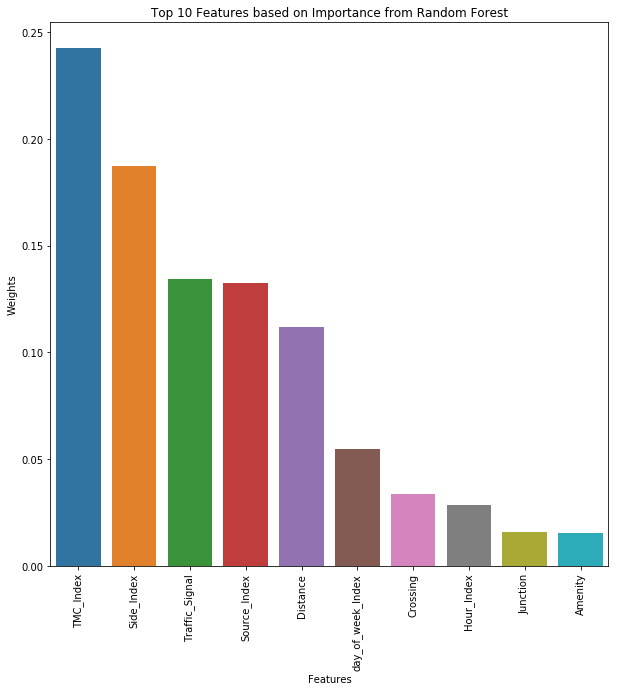

In [23]:
# Plotting top 10 Features from Feature Importance of RF Base Model for Multiclass Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_rfm['column'][:10], y=feat_imp_tuned_rfm['weight'][:10],data=feat_imp_tuned_rfm)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from Random Forest");

# Multiclass RF Grid Search Model

In [24]:
# Create an initial RandomForest model.

rf_new = RandomForestClassifier(labelCol="label", featuresCol="features",seed=42)

# Creating pipeline for RF Grid Model 

rfModel_new = Pipeline(stages=[label_stringIdx,va, rf_new])

In [25]:
# Creating Grid Search for Hyper Parameter Tuning

#paramGrid_rf = ParamGridBuilder().addGrid(rf_new.numTrees, [10, 25, 60]).addGrid(rf_new.maxDepth, [3, 5, 10]).addGrid(rf_new.impurity,["entropy", "gini"]).build()

paramGrid_rf = ParamGridBuilder().addGrid(rf_new.numTrees, [60]).addGrid(rf_new.maxDepth, [10]).addGrid(rf_new.impurity,["entropy"]).build()

In [26]:
# Cross Validator with 5 fold and Grid Search to fit the training data

cv_rf = CrossValidator(estimator=rfModel_new, estimatorParamMaps=paramGrid_rf, evaluator=evaluator, numFolds=5).fit(us_train_cat)

In [27]:
# Transform Test data using Cross Validation Pipeline Built earlier for prediction of Test data

pred_rft = cv_rf.transform(us_test_cat)

In [28]:
# Evaluation of model using Multiclass Evaluator on Test data

print("Accuracy:",evaluator.evaluate(pred_rft))

Accuracy: 0.7203679986120962


In [29]:
prediction_rf=cv_rf.transform(us_test_cat).toPandas()["prediction"]

In [30]:
true_labels=us_test_cat.toPandas()["Severity"]

In [31]:
from sklearn.metrics import classification_report

In [32]:
print(classification_report(y_pred=prediction_rf,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.73      0.92      0.82    131571
           1       0.65      0.33      0.44     58293
           2       0.62      0.07      0.13      6115

   micro avg       0.72      0.72      0.72    195979
   macro avg       0.67      0.44      0.46    195979
weighted avg       0.71      0.72      0.68    195979



In [33]:
# Best Model Hyper Parameters after tuning

cv_rf.bestModel.stages[-1].extractParamMap()

{Param(parent='RandomForestClassifier_d70a92d04e27', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_d70a92d04e27', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_d70a92d04e27', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_d70a92d04e27', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_d70a92d04e27', 

In [34]:
# Creating Pandas Dataframe for Features and their Importance of RF Grid Model for Multiclass Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_rft = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], cv_rf.bestModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

Text(0.5,1,'Top 10 Features based on Importance from Random Forest Grid Model')

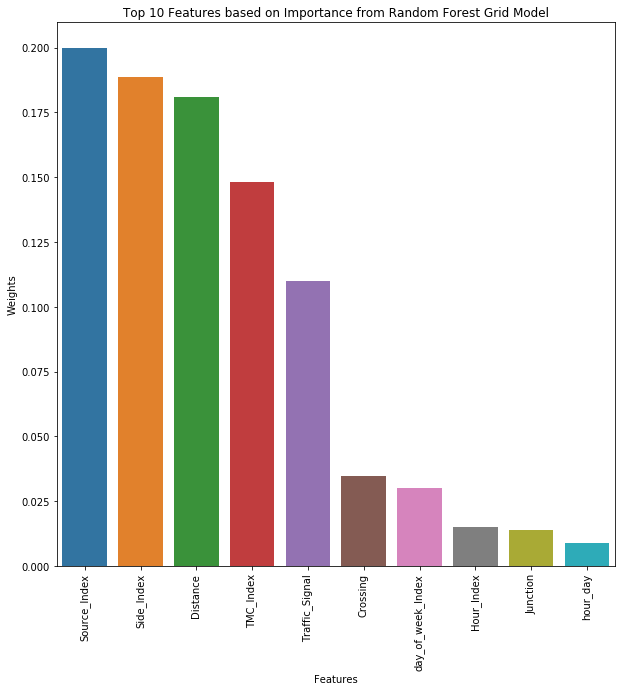

In [35]:
# Plotting top 10 Features from Feature Importance of RF Grid Model for Multiclass Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_rft['column'][:10], y=feat_imp_tuned_rft['weight'][:10],data=feat_imp_tuned_rft)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from Random Forest Grid Model")

In [36]:
# Tree from the best Model printing it 

print(cv_rf.bestModel.stages[-1].trees[3].toDebugString)

DecisionTreeClassificationModel (uid=dtc_eb02160664ee) of depth 10 with 729 nodes
  If (feature 35 <= 3.5)
   If (feature 36 <= 34.5)
    If (feature 32 <= 0.5)
     If (feature 39 <= 13.5)
      If (feature 16 <= 0.0105)
       If (feature 16 <= 0.009999999888240001)
        If (feature 34 <= 0.5)
         If (feature 37 <= 0.5)
          Predict: 0.0
         Else (feature 37 > 0.5)
          If (feature 38 <= 0.5)
           Predict: 0.0
          Else (feature 38 > 0.5)
           If (feature 18 <= 77.5)
            Predict: 0.0
           Else (feature 18 > 77.5)
            Predict: 2.0
        Else (feature 34 > 0.5)
         Predict: 0.0
       Else (feature 16 > 0.009999999888240001)
        If (feature 38 <= 0.5)
         If (feature 27 <= 0.5)
          If (feature 19 <= 29.095)
           If (feature 40 <= 9.5)
            Predict: 0.0
           Else (feature 40 > 9.5)
            Predict: 1.0
          Else (feature 19 > 29.095)
           If (feature 40 <= 6.5)
         

# Decision Tree Base Model Multiclass Classification

In [37]:

from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Creating pipeline for DT Base Model 

dt_pipe = Pipeline(stages=[label_stringIdx, va, dt])

# Train DT Base model with Training Data

dtModel = dt_pipe.fit(us_train_cat)

In [38]:
# Multiclass Evaluator to evaluate the performance of the model 

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [39]:
# Transform Test data using Fitted Pipeline Built earlier for prediction of Test data

pred_dt = dtModel.transform(us_test_cat)

In [40]:
# Evaluation of model using Multiclass Evaluator on Test data

print("Accuracy:",evaluator_dt.evaluate(pred_dt))

Accuracy: 0.7120507809510203


In [41]:
prediction_dt=pred_dt.toPandas()["prediction"]

In [42]:
true_labels=us_test_cat.toPandas()["Severity"]

In [43]:
from sklearn.metrics import classification_report

In [44]:
print(classification_report(y_pred=prediction_dt,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81    131571
           1       0.60      0.36      0.45     58293
           2       0.50      0.22      0.31      6115

   micro avg       0.71      0.71      0.71    195979
   macro avg       0.61      0.49      0.52    195979
weighted avg       0.69      0.71      0.69    195979



In [45]:
# Creating Pandas Dataframe for Features and their Importance of DT Base Model for Multiclass Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_dt = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], dtModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

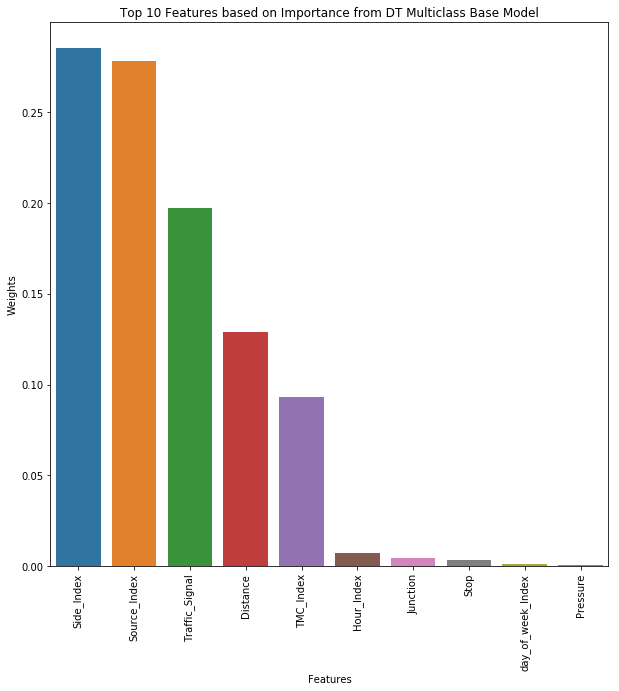

In [46]:
# Plotting top 10 Features from Feature Importance of DT Base Model for Multiclass Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_dt['column'][:10], y=feat_imp_tuned_dt['weight'][:10],data=feat_imp_tuned_dt)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from DT Multiclass Base Model");

# Decision Tree Grid Search Multiclass Classification

In [47]:

# Initializing DT Grid Pipeline 

dt_new = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Creating pipeline for DT Grid Model 

dt_new_pipe = Pipeline(stages=[label_stringIdx, va, dt_new])

# Creating Grid Search for Hyper Parameter Tuning for DT Model

#grid_dt = ParamGridBuilder().addGrid(dt_new.maxDepth, [10,15,30]).addGrid(dt_new.minInstancesPerNode, [500,1000,1500]).addGrid(dt_new.maxBins,[20,35,50]).build()
grid_dt = ParamGridBuilder().addGrid(dt_new.maxDepth,[30]).addGrid(dt_new.minInstancesPerNode, [500]).addGrid(dt_new.maxBins,[20]).build()
# Cross Validator Pipeline with 5 fold 

cv1_dt = CrossValidator(estimator=dt_new_pipe,estimatorParamMaps=grid_dt, numFolds=5, evaluator=evaluator_dt)

In [48]:
# Fitting the training data using the Cross Validator Pipeline 

dtModel_t = cv1_dt.fit(us_train_cat)

In [49]:
# Transform Test data using Cross Validation Pipeline Built earlier for prediction of Test data

pred_dtt = dtModel_t.transform(us_test_cat)

In [50]:
# Evaluation of Testing Data using Multiclass Evaluator 

print("Accuracy:",evaluator_dt.evaluate(pred_dtt))

Accuracy: 0.7259502293613092


In [51]:
dtModel_t.bestModel.stages[-1].extractParamMap()

{Param(parent='DecisionTreeClassifier_90ff862f7958', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='DecisionTreeClassifier_90ff862f7958', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='DecisionTreeClassifier_90ff862f7958', name='featuresCol', doc='features column name'): 'features',
 Param(parent='DecisionTreeClassifier_90ff862f7958', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini',
 Param(parent='DecisionTreeClassifier_90ff862f7958', name='labelCol', doc='label column name'): 'lab

In [76]:
# Decision Tree Hyper Parameter Value Max Bins from Best Model

dtModel_t.bestModel.stages[-1].getMaxBins()

AttributeError: 'DecisionTreeClassificationModel' object has no attribute 'getMaxBins'

In [85]:
# Decision Tree Hyper Parameter Value Max Depth from Best Model

dtModel_t.bestModel.stages[-1].getMaxDepth()

30

In [86]:
# Decision Tree Hyper Parameter Value Minimum Instances Per Node from Best Model

dtModel_t.bestModel.stages[-1].getMinInstancesPerNode()

500

In [52]:
prediction_dtt=pred_dtt.toPandas()["prediction"]

In [53]:
true_labels=us_test_cat.toPandas()["Severity"]

In [54]:
from sklearn.metrics import classification_report

In [55]:
print(classification_report(y_pred=prediction_dtt,y_true=true_labels))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81    131571
           1       0.61      0.47      0.53     58293
           2       0.51      0.22      0.31      6115

   micro avg       0.73      0.73      0.73    195979
   macro avg       0.63      0.52      0.55    195979
weighted avg       0.71      0.73      0.71    195979



In [56]:
# Creating Pandas Dataframe for Features and their Importance of DT Grid Model for Multiclass Classification

pd.set_option('display.max_rows', None)
feat_imp_tuned_dtt = pd.DataFrame(list(zip([i for i in us_train_cat.columns if i!='Severity'], dtModel_t.bestModel.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight',ascending=False)

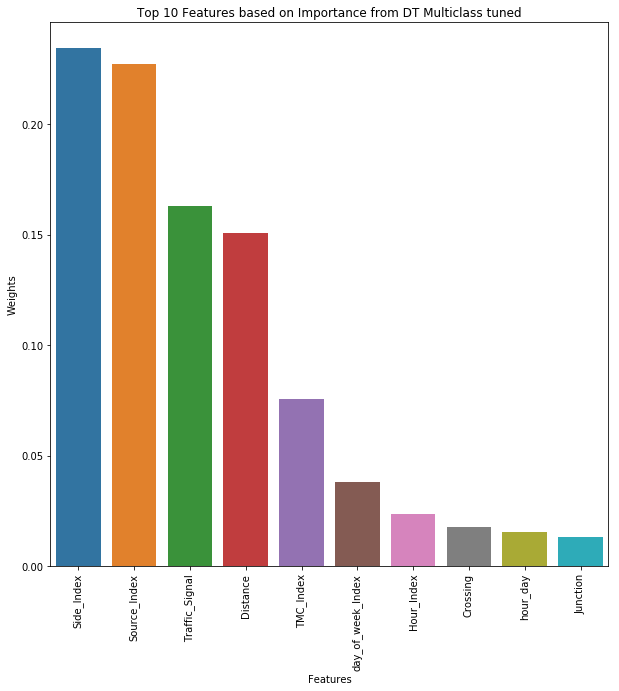

In [57]:
# Plotting top 10 Features from Feature Importance of DT Grid Model for Multiclass Classification

plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp_tuned_dtt['column'][:10], y=feat_imp_tuned_dtt['weight'][:10],data=feat_imp_tuned_dtt)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Top 10 Features based on Importance from DT Multiclass tuned");